In [ ]:
print(("Let's get this money!!"))

Let's get this money!!


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/HW5_train_val.zip /content
!unzip HW5_train_val.zip

Mounted at /content/gdrive
Archive:  HW5_train_val.zip
 extracting: DIV2K_train_HR.zip      
 extracting: DIV2K_train_LR_bicubic_X4.zip  
 extracting: DIV2K_valid_HR.zip      
 extracting: DIV2K_valid_LR_bicubic_X4.zip  


In [ ]:
!mkdir /content/valid_HR/
!mkdir /content/train_HR/

!mv DIV2K_train_HR.zip /content/train_HR/  
!mv DIV2K_valid_HR.zip /content/valid_HR/

!unzip /content/train_HR/DIV2K_train_HR.zip -d /content/train_HR/
!unzip /content/DIV2K_train_LR_bicubic_X4.zip -d /content/train_LR/
!unzip /content/valid_HR/DIV2K_valid_HR.zip -d /content/valid_HR/
!unzip /content/DIV2K_valid_LR_bicubic_X4.zip -d /content/valid_LR/



In [1]:
import numpy as np
import torch
import torchvision   
import torch.nn as nn
from torchvision import transforms

import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torch.utils.data import Dataset, DataLoader
cuda = torch.device('cuda')
cpu = torch.device('cpu')
device = cuda

BATCH_SIZE = 32

In [ ]:
# To build SRGAN, let's start with a residual block.
# This is adapted from HW2, itself adapted from instructor-provided code
# this is a simpler residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channel=64, main_channel=64, stride=1, step=False):
        super().__init__()

        self.in_channel = in_channel
        self.main_channel = main_channel
        self.step = step
        channel_size = main_channel
        self.conv1 = nn.Conv2d(in_channel, channel_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(channel_size, channel_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_size)
        self.bn2 = nn.BatchNorm2d(channel_size)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)

        if stride == 1 and (in_channel == main_channel):
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channel, channel_size, kernel_size=1, stride=stride, padding=0, bias=False),
                                          nn.BatchNorm2d(channel_size))
        self.prelu_1 = torch.nn.PReLU()
        self.prelu_2 = torch.nn.PReLU()
    
    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu_1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        shortcut = self.shortcut(x)
        return out + shortcut

In [ ]:
## Creating the network

class DBlock(nn.Module):
    def __init__(self, in_, n, k, s):
        super(DBlock, self).__init__()
        self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_, out_channels=n, kernel_size=k, stride=s, padding=1),
        nn.BatchNorm2d(n),
        nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.layers.forward(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(SRGAN_Discriminator, self).__init__()

        self.layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.LeakyReLU(0.2),
        DBlock(64, 64, 3, 2),

        DBlock(64, 128, 3, 1),
        DBlock(128, 128, 3, 2),

        DBlock(128, 256, 3, 1),
        DBlock(256, 256, 3, 2),

        DBlock(256, 512, 3, 1),
        DBlock(512, 512, 3, 2),

        nn.AdaptiveAvgPool2d(1),

        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1),
        nn.Sigmoid())

    def forward(self, x):
    
        return self.layers.forward(x)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        upsample_block_num = 2

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        out1 = self.block1(x)
        out = self.block2(out1)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        out = self.block8(out1 + out)

        return (torch.tanh(out) + 1) / 2

class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

# to create a new one or load
#generator = Generator()
#generator = torch.load("/content/gdrive/MyDrive/gen.pth")
discriminator = Discriminator()

In [4]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# datasets = torchvision.datasets.ImageFolder(root='/home/ubuntu/content/DIV2K_valid_LR_bicubic')
train_dataset_LR = torchvision.datasets.ImageFolder(root='/content/train_LR/', 
                                                   transform=transform_train)
# dev_dataset_HR = torchvision.datasets.ImageFolder(root='/content/DIV2K_valid_HR/')
train_dataset_HR = torchvision.datasets.ImageFolder(root='/content/train_HR/', 
                                                   transform=transform_train)

In [5]:
#transform below from:
#https://jbencook.com/pytorch-normalize/

# Comment from Shentong:
# We need to do transformation for VGG to extract the useful features.

# I am transforming the images, and I also am trying out a function that should
# transform them back to "normal".
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


# Here is the function to transform a normalized tensor into
# a tensor with the original mean and standard deviation.

def undo_transform(img_tensor):
    # Apply to individual images.
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    for i in range(img_tensor.shape[0]):
        img_tensor[i, :, :] = img_tensor[i, :, :] * std[i] + mean[i]
    return img_tensor

In [6]:
# Comment from Shentong:
# The patch method seems appropriate.

def patch_lr_hr(lr, hr):
    c, H, W = lr.shape
    c1, c2 = np.random.randint(0, H - PATCH_SIZE - 1), np.random.randint(0, W - PATCH_SIZE - 1)
    d1, d2 = 4 * c1, 4 * c2

    lr = lr[:, c1:(c1 + PATCH_SIZE), c2:(c2 + PATCH_SIZE)]
    hr = hr[:, d1:(d1 + 4 * PATCH_SIZE), d2:(d2 + 4 * PATCH_SIZE)]

    return lr, hr


In [7]:
class MyDataset(data.Dataset): ## for Generator data
    def __init__(self, LR, HR):
        self.LR_images = LR # img datafolders
        self.HR_images = HR # img datafolder

    def __len__(self):
        return len(self.LR_images)

    def __getitem__(self, index):
        LR = self.LR_images[index][0]
        HR = self.HR_images[index][0]
        #return LR, HR
        return patch_lr_hr(LR, HR)

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


In [ ]:
# have to move all files from folder level to subfolder level... ?!?!?!?

In [19]:
PATCH_SIZE = 64

full_train_data = MyDataset(train_dataset_LR, train_dataset_HR)
# full_valid_data = MyDataset(valid_folder_LR, valid_folder_HR)

train_loader = DataLoader(full_train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
# test_loader = DataLoader(full_valid_data, batch_size=BATCH_SIZE)

In [30]:
disc_loss = nn.BCELoss()
Generator = Generator()
Discriminator = Discriminator()
l1 = torch.nn.L1Loss()

def gen_loss(lr, hr, disc_output):
    # Weight is a hyperparameter
    # Try other weights. Try powers of 10... 1e-2, 1e-4...
    
    # here the version for low gradients is implemented, i.e. when discriminator
    # easily discriminates, the disc_output loss is low, so instead of minimizing log(1-disc_out) we
    # maximize log(disc_out) which is way bigger
    
    # But we should experiment when to include back the minimization and change or not the weight.
    
    content = l1(lr, hr)
    
    adversarial1 = torch.log(1-disc_output).mean()
    adversarial2 = -torch.log(disc_output).mean()
    
#     adversarial = -torch.log(disc_output).mean() # changed the loss to try with the other one, and it worked well
# for 10 epochs but then the loss were really low


    return content + WEIGHT_ADVERS * (adversarial1+adversarial2)

In [ ]:
# this loss function is adapted from a github implementation
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg19(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:18]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        # self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        # tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss # + 2e-8 * tv_loss


In [10]:
lr = 0.001
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [11]:
G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(G_optimizer, factor=0.8, patience=3, verbose=True)
D_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(D_optimizer, factor=0.8, patience=3, verbose=True)

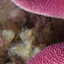

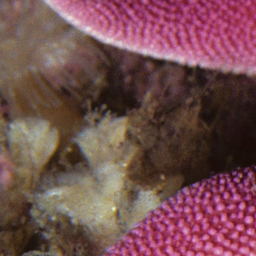

In [12]:
# test display
_ = next(iter(train_loader))
_lr, _hr = _[0][0], _[1][0]
display(transforms.ToPILImage()(undo_transform(_lr)).convert("RGB"))
display(transforms.ToPILImage()(undo_transform(_hr)).convert("RGB"))

epoch is done:  0
with L1 loss:  19.72466552257538
with SSIM:  4.245180577039719
Epoch    15: reducing learning rate of group 0 to 6.4000e-04.


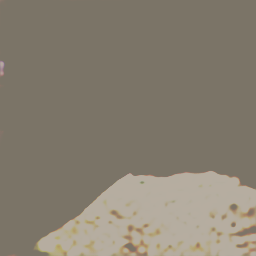

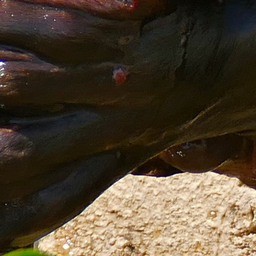

epoch is done:  1
with L1 loss:  19.70157027244568
with SSIM:  4.342501446604729


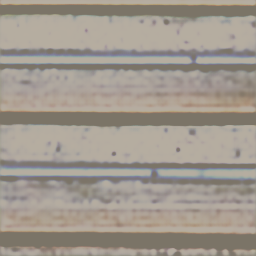

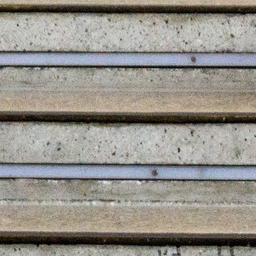

epoch is done:  2
with L1 loss:  19.605121314525604
with SSIM:  4.765789404511452


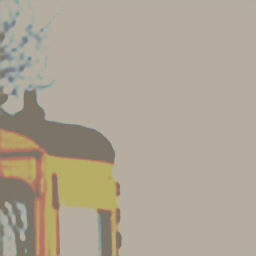

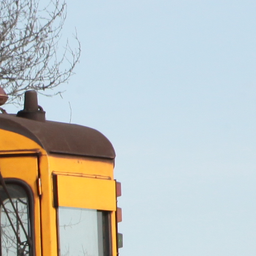

epoch is done:  3
with L1 loss:  19.51870357990265
with SSIM:  4.550809010863304


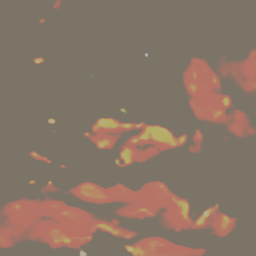

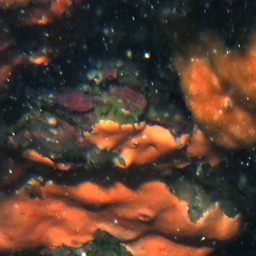

epoch is done:  4
with L1 loss:  19.39448219537735
with SSIM:  4.594898551702499
Epoch    19: reducing learning rate of group 0 to 5.1200e-04.


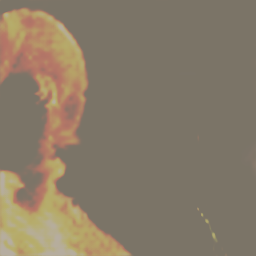

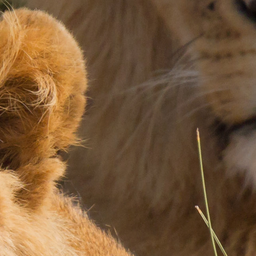

epoch is done:  5
with L1 loss:  19.62556082010269
with SSIM:  4.363974913954735


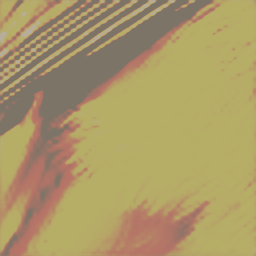

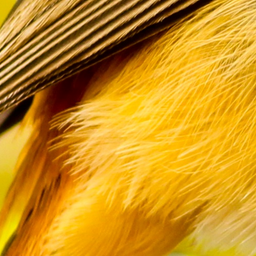

epoch is done:  6
with L1 loss:  19.307436525821686
with SSIM:  4.708816207945347


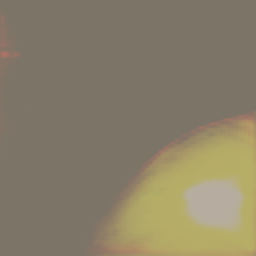

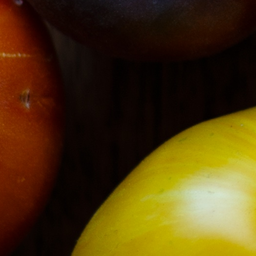

epoch is done:  7
with L1 loss:  19.23791867494583
with SSIM:  4.647570461034775


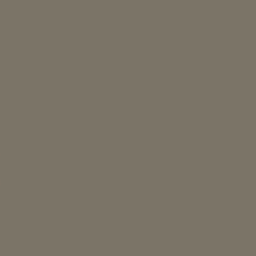

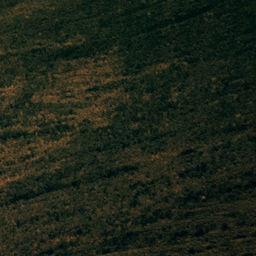

epoch is done:  8
with L1 loss:  19.148652732372284
with SSIM:  4.8109052032232285
Epoch    23: reducing learning rate of group 0 to 4.0960e-04.


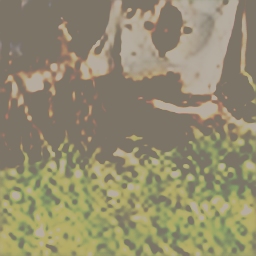

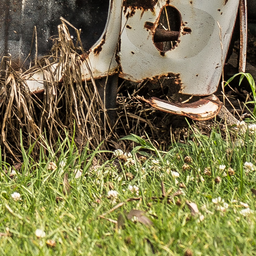

epoch is done:  9
with L1 loss:  19.451388001441956
with SSIM:  4.693777620792389


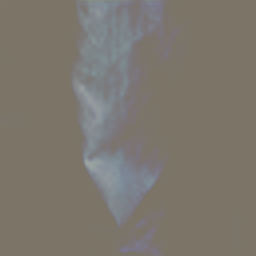

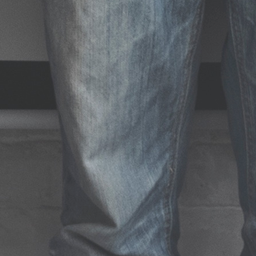

epoch is done:  10
with L1 loss:  19.261335849761963
with SSIM:  4.71171572804451


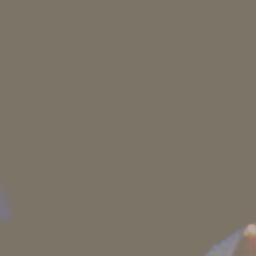

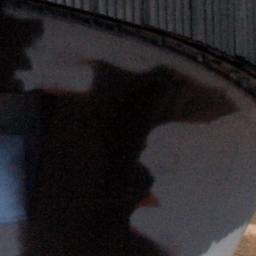

epoch is done:  11
with L1 loss:  19.36174303293228
with SSIM:  4.838326349854469


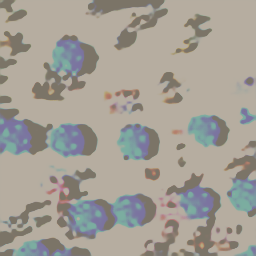

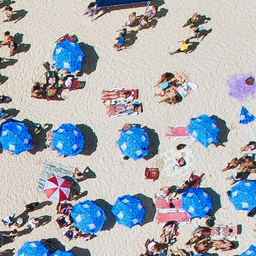

epoch is done:  12
with L1 loss:  19.293435752391815
with SSIM:  4.53298082947731
Epoch    27: reducing learning rate of group 0 to 3.2768e-04.


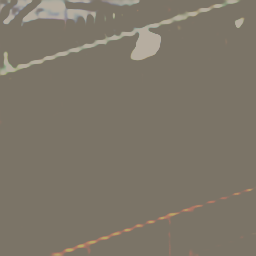

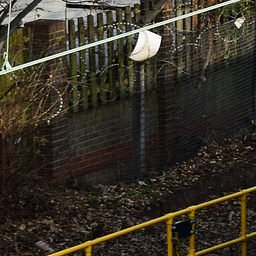

epoch is done:  13
with L1 loss:  19.323833286762238
with SSIM:  4.64664414525032


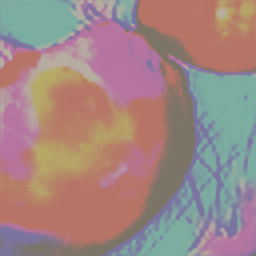

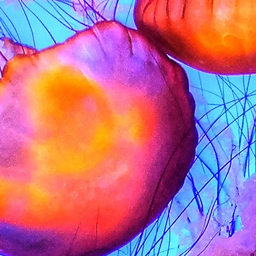

epoch is done:  14
with L1 loss:  19.40072751045227
with SSIM:  4.620001450181007


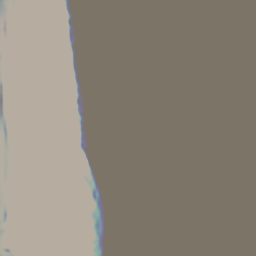

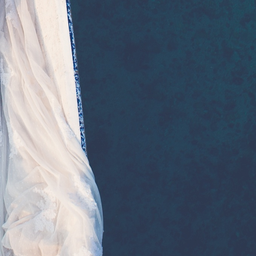

epoch is done:  15
with L1 loss:  19.188892722129822
with SSIM:  4.755983397364616


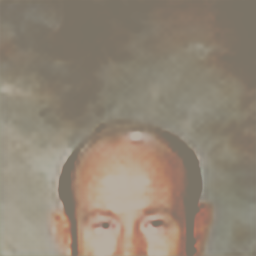

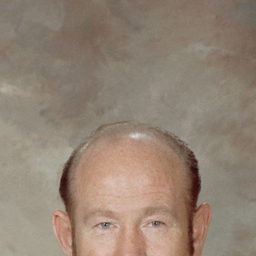

epoch is done:  16
with L1 loss:  19.67049527168274
with SSIM:  4.4708883464336395
Epoch    31: reducing learning rate of group 0 to 2.6214e-04.


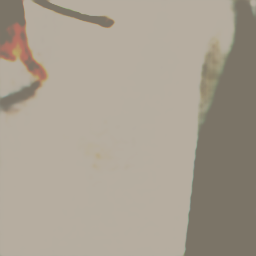

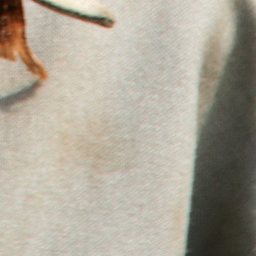

epoch is done:  17
with L1 loss:  19.278235256671906
with SSIM:  4.6105876713991165


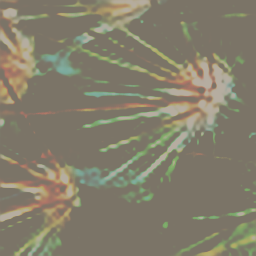

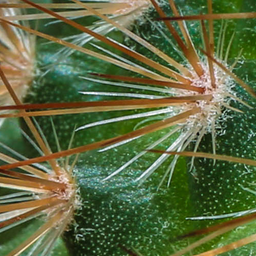

epoch is done:  18
with L1 loss:  19.326631009578705
with SSIM:  4.681192755699158


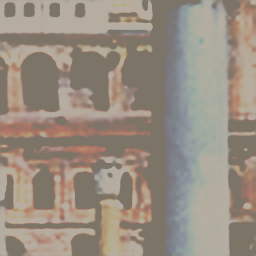

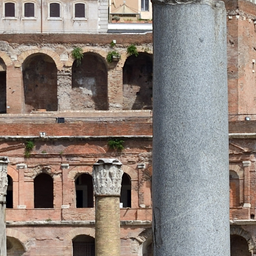

epoch is done:  19
with L1 loss:  18.79252862930298
with SSIM:  4.73358653485775


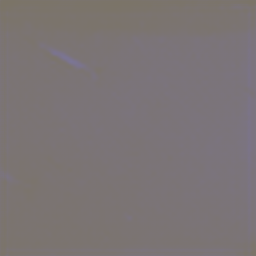

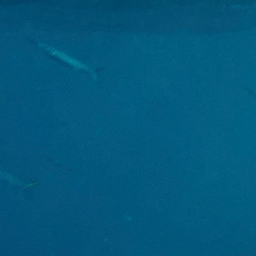

epoch is done:  20
with L1 loss:  18.85604739189148
with SSIM:  4.873064160346985
Epoch    35: reducing learning rate of group 0 to 2.0972e-04.


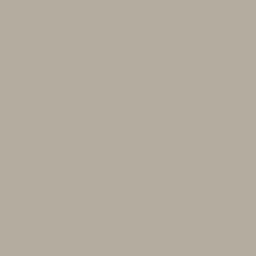

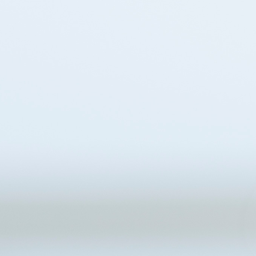

epoch is done:  21
with L1 loss:  19.600565910339355
with SSIM:  4.617304183542728


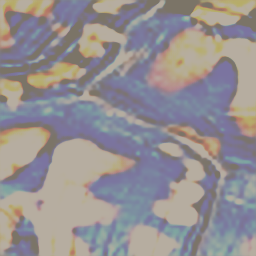

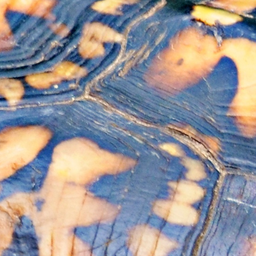

epoch is done:  22
with L1 loss:  19.16670972108841
with SSIM:  4.668041989207268


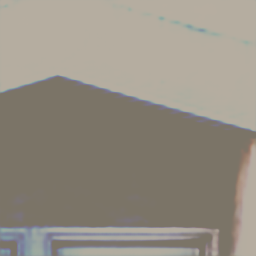

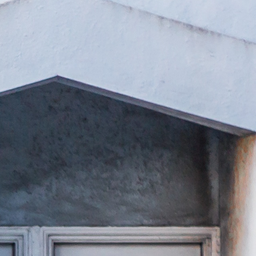

In [ ]:
# Pretrain the generator
# Shentong suggests 50 epochs is good for this.

nepochs = 50
pretrain_loss = torch.nn.L1Loss()
# pretrain_loss = 

# uncomment this if no optimizer initialized already.
# lr = 0.0005
# G_optimizer = optim.Adam(Generator.parameters(), lr=lr)

i = 0
total_loss = []
generator.to(cuda)
generator.train()
j = 0

for epoch in range(nepochs): # using the same i in the loop ?!
    generator.train()

    epoch_l1 = 0
    epoch_ssim = 0

    for obj in train_loader:
        generator.zero_grad()
        G_optimizer.zero_grad()

        lr, hr = obj
        lr = lr.to(cuda)
        # display(transforms.ToPILImage()(undo_transform(lr[0])).convert("RGB"))
        hr = hr.to(cuda)

        sr = generator.forward(lr)
        loss = pretrain_loss(sr, hr)
        ssimloss = 1-pytorch_ssim.ssim(sr, hr)
        loss.backward()
        G_optimizer.step()

        epoch_ssim += ssimloss.item()
        epoch_l1 += loss.item()


    print("epoch is done: ", epoch)
    print("with L1 loss: ", epoch_l1)
    print("with SSIM: ", epoch_ssim)
    G_scheduler.step(epoch_ssim)

    display(transforms.ToPILImage()(undo_transform(sr[0])).convert("RGB"))
    display(transforms.ToPILImage()(undo_transform(hr[0])).convert("RGB"))

In [73]:
torch.save(generator,"/content/gdrive/MyDrive/gen.pth")

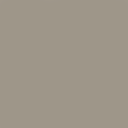

In [43]:
# Train both
# Pretrain the generator
# Shentong suggests 50 epochs is good for this.

nepochs = 50
pretrain_loss = torch.nn.L1Loss()
generator_loss = GeneratorLoss() 

# uncomment this if no optimizer initialized already.
# lr = 0.0005
# G_optimizer = optim.Adam(Generator.parameters(), lr=lr)

i = 0
total_loss = []
generator.to(cuda)
generator.train()
j = 0

for epoch in range(nepochs): # using the same i in the loop ?!
    generator.train()

    epoch_l1 = 0
    epoch_ssim = 0

    for obj in train_loader:

        generator.zero_grad()
        discriminator.zero_grad()
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()

        lr, hr = obj
        lr = lr.to(cuda)
        hr = hr.to(cuda)
        sr = generator.forward(lr)
        
        real_out = netD(hr).mean()
        fake_out = netD(sr).mean()
        
        d_loss = 1 - real_out + fake_out
        d_loss.backward()
        D_optimizer.step()

        generator.zero_grad()
        g_loss = generator_loss(fake_out, sr, hr)
        g_loss.backward()
        G_optimizer.step()


        ssimloss = 1 - pytorch_ssim.ssim(sr, hr)
        epoch_ssim += ssimloss.item()


    print("epoch is done: ", epoch)
    print("with L1 loss: ", epoch_l1)
    print("with SSIM: ", epoch_ssim)
    G_scheduler.step(epoch_ssim)

    display(transforms.ToPILImage()(undo_transform(sr[0])).convert("RGB"))
    display(transforms.ToPILImage()(undo_transform(hr[0])).convert("RGB"))

In [15]:
#!git clone https://github.com/Po-Hsun-Su/pytorch-ssim
import pytorch_ssim

In [ ]:
# used from this line

In [ ]:
def save_checkpoint(state, is_best, filename=content_path+'Generator_trained2.tar'):
    torch.save(state, filename)
#     if is_best:
#         shutil.copyfile(filename, 'model_best.pth.tar')

In [ ]:
# recover the Generator saved
checkpoint = torch.load(content_path+'Generator_trained.tar')

# start_epoch = checkpoint['epoch']
Generator.load_state_dict(checkpoint['state_dict'])
G_optimizer.load_state_dict(checkpoint['optimizer'])

for state in G_optimizer.state.values():
    for k, v in state.items():
        if torch.is_tensor(v):
            state[k] = v.cuda()

In [ ]:
########### TRY TO TRAIN STARTING WITH THE OTHER LOSS FUNCTION for start 

In [ ]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        if not img1.shape == img2.shape:
          raise ValueError("Input images must have same shapes")
        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(255.0 / torch.sqrt(mse))

discriminator L1 loss for prediction:  0.10426683723926544
discriminator L1 loss for prediction:  0.11733012646436691
discriminator L1 loss for prediction:  0.11151190474629402
discriminator L1 loss for prediction:  0.13881375081837177
discriminator L1 loss for prediction:  0.12904191762208939


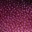

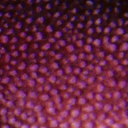

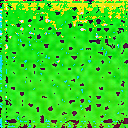

epoch done:  1  and discriminator & generator training losses for this epoch:
[0.202, 0.3271, 0.2002, 0.3898, 0.24, 0.5653, 0.4691, 0.147, 0.3872, 0.2209, 0.7153, 0.456, 0.8234, 0.9547, 1.825, 0.306, 0.5599, 0.8066, 0.2879, 0.3058, 0.3913, 0.2924, 0.5119, 0.2213, 0.3515, 0.5492, 0.5019, 0.4111, 0.3636, 0.3463, 0.6448, 0.4552, 0.8955, 0.2302, 0.4015, 0.6064, 0.5102, 0.0862, 0.4708, 0.4113, 0.4443, 0.3793, 0.3597, 0.3641, 0.3326, 0.2854, 0.3126, 0.3729, 0.6979, 0.2904]
[0.1285, 0.1325, 0.1259, 0.1243, 0.1039, 0.1003, 0.0876, 0.1257, 0.1027, 0.1061, 0.1332, 0.1118, 0.1118, 0.1214, 0.0883, 0.1213, 0.0906, 0.0886, 0.108, 0.1386, 0.1104, 0.1133, 0.0907, 0.1032, 0.1198, 0.1226, 0.0886, 0.1173, 0.1198, 0.1103, 0.1114, 0.0824, 0.0915, 0.1141, 0.1492, 0.1507, 0.1044, 0.1636, 0.1267, 0.0879, 0.1445, 0.1084, 0.0915, 0.1024, 0.1046, 0.1099, 0.1119, 0.1162, 0.1343, 0.128]
discriminator L1 loss for prediction:  0.1464274302124977
discriminator L1 loss for prediction:  0.10762297734618187
discriminato

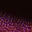

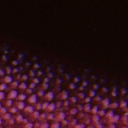

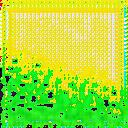

epoch done:  2  and discriminator & generator training losses for this epoch:
[0.4572, 0.6226, 0.4447, 0.424, 1.0591, 0.6518, 0.4715, 0.3585, 0.5101, 0.3014, 0.1794, 0.2526, 0.396, 0.5264, 0.2628, 0.471, 0.418, 0.2155, 0.1145, 0.1493, 0.2427, 0.2742, 0.1876, 0.0428, 0.0911, 0.4065, 0.4096, 0.5145, 1.1988, 0.3407, 0.5454, 0.2883, 0.2771, 0.7809, 0.9841, 1.0805, 0.7232, 0.4106, 0.6522, 0.6957, 0.4393, 0.367, 0.567, 0.6634, 0.5627, 0.52, 0.65, 0.5045, 0.4792, 0.4995]
[0.1085, 0.1077, 0.1243, 0.1258, 0.0994, 0.0958, 0.1152, 0.128, 0.1191, 0.1297, 0.1258, 0.1152, 0.1123, 0.1229, 0.0904, 0.106, 0.0917, 0.1062, 0.1349, 0.1045, 0.1225, 0.0891, 0.1058, 0.1402, 0.1042, 0.1369, 0.0928, 0.1088, 0.1193, 0.1104, 0.0987, 0.1099, 0.1364, 0.1158, 0.09, 0.1138, 0.1045, 0.1315, 0.1148, 0.1019, 0.1534, 0.1319, 0.1035, 0.0979, 0.1039, 0.1074, 0.1094, 0.1121, 0.1466, 0.0952]
discriminator L1 loss for prediction:  0.1546134501695633
discriminator L1 loss for prediction:  0.05151782184839249
discriminator L1 

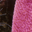

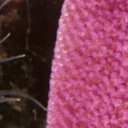

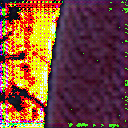

epoch done:  3  and discriminator & generator training losses for this epoch:
[0.6299, 0.402, 0.555, 0.2847, 0.5026, 0.2783, 0.2061, 0.1797, 0.3065, 0.5214, 0.2813, 0.1199, 0.2688, 0.2022, 0.527, 0.6061, 1.0183, 1.2496, 1.4265, 0.9193, 0.9871, 0.6303, 0.7961, 0.3949, 0.2846, 0.6287, 0.9127, 0.837, 0.5271, 0.6715, 0.9313, 0.7087, 0.749, 0.5218, 0.6463, 0.6454, 0.6828, 0.6537, 0.7613, 0.531, 0.4512, 0.3544, 0.5073, 0.6108, 0.3143, 0.502, 0.8373, 0.3411, 0.1907, 0.3857]
[0.0954, 0.1175, 0.0814, 0.1054, 0.103, 0.1132, 0.1237, 0.1263, 0.1383, 0.1227, 0.1086, 0.1553, 0.0784, 0.1234, 0.1076, 0.1492, 0.1028, 0.1201, 0.1117, 0.1022, 0.1059, 0.0921, 0.119, 0.1224, 0.1326, 0.1338, 0.0697, 0.1066, 0.0994, 0.1055, 0.0791, 0.113, 0.134, 0.0897, 0.0846, 0.128, 0.1159, 0.1101, 0.1031, 0.0941, 0.114, 0.1101, 0.1415, 0.0993, 0.1395, 0.0856, 0.0928, 0.1116, 0.15, 0.0967]
discriminator L1 loss for prediction:  0.11917105317115784
discriminator L1 loss for prediction:  0.11941885203123093
discriminator L1 

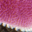

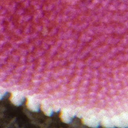

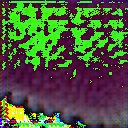

epoch done:  4  and discriminator & generator training losses for this epoch:
[0.4245, 0.3274, 0.6096, 0.3353, 0.418, 0.1247, 0.2751, 0.731, 0.4073, 0.259, 0.5517, 0.4085, 0.156, 0.0831, 0.6364, 0.7288, 0.8047, 0.6788, 0.5581, 0.3834, 0.5114, 0.3837, 0.4811, 0.4774, 0.2259, 0.7644, 0.4015, 0.7837, 0.4681, 0.4809, 0.5234, 0.362, 0.568, 0.4415, 0.4826, 0.3554, 0.248, 0.4299, 0.3013, 0.5494, 0.0895, 0.1745, 0.5799, 0.5684, 0.4796, 0.4615, 0.6458, 0.2955, 0.4471, 0.3639]
[0.1035, 0.1022, 0.1036, 0.1086, 0.1167, 0.1288, 0.1093, 0.0992, 0.1066, 0.1061, 0.1516, 0.1051, 0.1119, 0.1338, 0.0958, 0.0979, 0.1016, 0.0952, 0.0916, 0.0962, 0.1163, 0.1292, 0.097, 0.1135, 0.1214, 0.1231, 0.0958, 0.1089, 0.1058, 0.11, 0.0976, 0.1153, 0.1019, 0.0863, 0.1052, 0.1209, 0.1099, 0.139, 0.1117, 0.1292, 0.1423, 0.1133, 0.1043, 0.1111, 0.0883, 0.0964, 0.1021, 0.1128, 0.1411, 0.1146]
discriminator L1 loss for prediction:  0.12619800865650177
discriminator L1 loss for prediction:  0.07514744810760021
discriminator

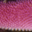

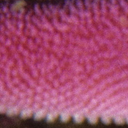

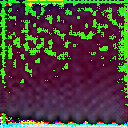

epoch done:  5  and discriminator & generator training losses for this epoch:
[0.2363, 0.3727, 0.2789, 0.1969, 0.3159, 0.2136, 0.1319, 0.4045, 0.2022, 0.6407, 0.257, 0.2714, 0.3556, 0.2439, 0.0669, 0.3953, 0.6424, 0.6605, 0.2011, 0.3201, 0.2256, 0.2669, 0.2882, 0.2367, 0.3304, 0.4445, 0.9008, 0.1545, 0.4071, 0.9267, 0.4793, 0.4564, 0.4349, 0.7052, 0.4864, 0.4194, 0.5344, 0.6954, 0.5094, 0.4813, 0.7974, 0.3451, 0.5311, 0.3788, 0.4573, 0.7301, 0.5016, 0.3649, 0.4186, 0.2663]
[0.101, 0.1246, 0.1172, 0.1296, 0.097, 0.1202, 0.1008, 0.1013, 0.1354, 0.1179, 0.1061, 0.1204, 0.1014, 0.1109, 0.1292, 0.0962, 0.0807, 0.0939, 0.1247, 0.0986, 0.1156, 0.1285, 0.107, 0.1099, 0.1385, 0.1268, 0.0975, 0.1247, 0.0951, 0.0951, 0.1067, 0.1333, 0.152, 0.091, 0.1444, 0.1595, 0.1187, 0.1388, 0.1379, 0.113, 0.131, 0.1379, 0.1015, 0.1017, 0.1152, 0.0822, 0.0912, 0.1038, 0.1287, 0.1492]
discriminator L1 loss for prediction:  0.12207570672035217
discriminator L1 loss for prediction:  0.12904246896505356
discrimina

In [ ]:
nepochs = 150

# trying learning rate lr = 0.0001 (in paper: somewhere between 10-4 and 10-5)

# Shentong's comments:


# Early stopping may be important
# Idea: add PSNR metric for testing.
# Implement PSNR metric; print out the value and check it every so often

gen_l, disc_l = [], []
for i in range(nepochs):
    disc_losses = []
    gen_losses = []
    
    # in the paper they alternate training the discriminator and the generator (k=1, see paper 3.2)
    
    # strange, here the discriminator is fully trained on all batches and then generator also
    # but they should be trained successively on batches I assume
    
    
    # Train the discriminator
    for k, obj in enumerate(train_loader):
        lr, hr = obj
        Generator.to(cuda)
        Generator.eval()
        with torch.no_grad():
            lr = lr.to(cuda)
            z = Generator.forward(lr)
        z = z.to(cuda)
        Discriminator.to(cuda)
        
        # the train function uses the optimizer defined above: D_optimizer (global variable)
        loss, 'avg_l1' = discriminator_train(hr, z, disc_loss) #disc loss is a bad name -- this is the discriminator loss
        
        if k%10==1:
            print("discriminator L1 loss for prediction: ", avg_l1)
            
        torch.cuda.empty_cache()
        disc_losses.append(round(loss, 4))

    # Train the generator
#     for obj in train_loader: 

        Discriminator.eval()
        lr, hr = obj
        # the train function uses the optimizer defined above: G_optimizer (global variable)
        loss = generator_train(lr, hr, gen_loss)
        torch.cuda.empty_cache()
        gen_losses.append(round(loss, 4))

        
    # tried to open x, y = full_train_data[0] but need to undo the normalization to visualize it properly
    x, y = full_train_data[0]
    display(transforms.ToPILImage()(undo_transform(x)).convert("RGB"))
    display(transforms.ToPILImage()(undo_transform(y)).convert("RGB"))
    x = x.to(cuda)
    z = Generator(x.unsqueeze(0)).squeeze(0)
    display(transforms.ToPILImage()(z.cpu()).convert("RGB"))
    
    print("epoch done: ", i+1, " and discriminator & generator training losses for this epoch:")
    print(disc_losses)
    print(gen_losses)

In [ ]:
# try to print the average of the distance to the real classes for discriminator to see if it learns or not and 
# if it does well since the start

In [ ]:
# comments here:

# issues with training images ? when try to print them they appear strangely as opposed to 
# when printed in the Generator training only (?!)

# solved (sould be) here: https://discuss.pytorch.org/t/understanding-transform-normalize/21730/18
# strange output is just that the train images are normalized btw 0,1 and matplotlib tries to rescale it to print.

# but doesn't explain why during the first generator only, the images are showed well




##### for validation images, consider adding the normalization also for validation purposes?
##### and undoing the normalization after passing into the generator? does this work?